In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mrmr import mrmr_classif

from src.machinelearning import (
    ANNClassifier,
    evaluate_ann,
    evaluate_sklearn,
    get_predictions,
    train_ann,
    train_decisiontree,
    train_skoperules,
    train_xgboost
)
from src.ml2rules import TreeRuler, ml2tree
from src.utils import get_cc_mat, get_dataset, non_stratify_split, stratify_split

In [3]:
def plot_cc_ranges(df: pd.DataFrame) -> None:
    # Change plot style
    plt.style.use("ggplot")
    # Calculate the 1st and 3rd quartiles of df values
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    # Plot the mean of df values
    plt.figure(figsize=(10, 3))
    plt.barh(df.columns[::-1], df.mean()[::-1])
    plt.axvline(x=0, color="black", linestyle="-")
    plt.plot(q1, df.columns, "|", color="black", label="Q1", alpha=1)
    plt.plot(q3, df.columns, "|", color="black", label="Q3", alpha=1)
    for i, enzyme in enumerate(df.columns):
        plt.plot([q1[i], q3[i]], [enzyme, enzyme], color="black")
    plt.title("CC_XTR")
    plt.grid()
    plt.show()
    
def get_value_counts(df: pd.DataFrame) -> None:
    display(
        pd.DataFrame(
        data=[df['label'].value_counts(normalize=True).round(4), df['label'].value_counts()],
        index=["percentage", "absolute"]    
    ).T
    )


### Data loading

***Dataset shape: (200000, 259)

Enzyme: XTR
Common enzymes: ['HXK', 'PGI', 'TPI', 'ZWF', 'ATPM', 'ADK', 'NDR', 'PDA', 'XTR', 'XRI', 'XDH', 'XK']
Number of all enzymes: 86


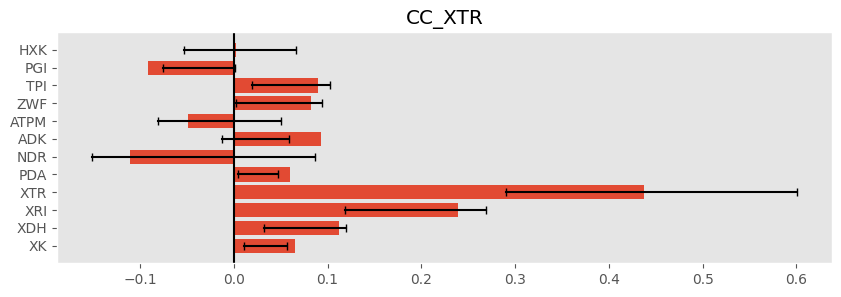

In [4]:
df = get_dataset(
    labels_file="../data/class_vector_train_ref.mat",
    params_file="../data/training_set_ref.mat",
    names_file="../data/paremeterNames.mat",
)

print(f"***Dataset shape: {df.shape}\n")

# Load FCC data
enzyme, commonEnz, allEnzymes, \
    commonConCoeff, allConCoeff = get_cc_mat("../data/ccXTR_ref.mat")

plot_cc_ranges(commonConCoeff)

In [7]:
# Create dataset for HXK enzyme; label 1 if CC < 0, 0 otherwise
idx_HXK = commonConCoeff[commonConCoeff["HXK"] < 0].index

df_HXK = df.drop("label", axis=1)
df_HXK["label"] = [1 if i in idx_HXK else 0 for i in df_HXK.index]
df_HXK["label"].value_counts(normalize=True).round(4)
df = df_HXK.copy()

# Create a dataframe with value_counts both percentage and absolute
display(
    pd.DataFrame(
    data=[df['label'].value_counts(normalize=True).round(4), df['label'].value_counts()],
    index=["percentage", "absolute"]    
).T
)

del df_HXK

,percentage,absolute
0,0.5287,105746.0
1,0.4713,94254.0


### Train - Test data split

In [9]:
# Split data
# X_train, X_test, y_train, y_test = non_stratify_split(
#     data=df, train_size=100000, target="label", zero_class_pct=0.60
# )

X_train, X_test, y_train, y_test = stratify_split(
    data=df, train_size=0.5, target="label"
)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print('Training set value counts:')
get_value_counts(train_df)

print('Test set value counts:')
get_value_counts(test_df)

Traininig set shape: (100000, 258)
Test set shape: (100000, 258)
Training set value counts:


,percentage,absolute
0,0.5287,52873.0
1,0.4713,47127.0


Test set value counts:


,percentage,absolute
0,0.5287,52873.0
1,0.4713,47127.0


### Feature Selection

In [11]:
K = int(df.drop("label", axis=1).shape[1] / 4)
print(f"***Number of features to select: {K}")
selected_features = mrmr_classif(X=df.drop("label", axis=1), y=df["label"], K=K)

***Number of features to select: 64


100%|██████████| 64/64 [00:49<00:00,  1.29it/s]


In [12]:
# keep only selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(f'Training set shape: {train_df.shape}')
print(f'Test set shape: {test_df.shape}')

Training set shape: (100000, 65)
Test set shape: (100000, 65)


### Machine Learning

##### Decision Tree - iSHRUNCK

In [10]:
cart_model = train_decisiontree(X_train, y_train, scoring='accuracy', n_trials=25)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.2s finished
[I 2024-09-30 15:41:55,823] Trial 17 finished with value: 0.5760400434147738 and parameters: {'max_depth': 17, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 13 with value: 0.6197100058238839.


[CV] END ................................ score: (test=0.572) total time=  27.5s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.621) total time=  11.3s
[CV] END ................................ score: (test=0.614) total time=  11.4s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.2s finished
[I 2024-09-30 15:42:08,196] Trial 18 finished with value: 0.6162300256229898 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 13 with value: 0.6197100058238839.


[CV] END ................................ score: (test=0.614) total time=  11.5s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
[I 2024-09-30 15:42:09,741] Trial 19 finished with value: 0.5553399525115429 and parameters: {'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 13 with value: 0.6197100058238839.


[CV] END ................................ score: (test=0.558) total time=   0.7s
[CV] END ................................ score: (test=0.560) total time=   0.7s
[CV] END ................................ score: (test=0.548) total time=   0.7s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.601) total time=  22.0s
[CV] END ................................ score: (test=0.601) total time=  22.1s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.2s finished
[I 2024-09-30 15:42:37,021] Trial 20 finished with value: 0.6020100133202688 and parameters: {'max_depth': 11, 'min_samples_split': 24, 'min_samples_leaf': 21, 'max_features': None}. Best is trial 13 with value: 0.6197100058238839.


[CV] END ................................ score: (test=0.604) total time=  26.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.609) total time=   9.2s
[CV] END ................................ score: (test=0.609) total time=   9.3s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s finished
[I 2024-09-30 15:42:47,004] Trial 21 finished with value: 0.6080400109214987 and parameters: {'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 13 with value: 0.6197100058238839.


[CV] END ................................ score: (test=0.607) total time=   9.2s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.6s finished
[I 2024-09-30 15:43:02,710] Trial 22 finished with value: 0.6194300006238799 and parameters: {'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 13 with value: 0.6197100058238839.


[CV] END ................................ score: (test=0.619) total time=  15.4s
[CV] END ................................ score: (test=0.619) total time=  15.4s
[CV] END ................................ score: (test=0.620) total time=  15.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.618) total time=  17.3s
[CV] END ................................ score: (test=0.618) total time=  17.3s
[CV] END ................................ score: (test=0.618) total time=  17.4s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.6s finished
[I 2024-09-30 15:43:20,397] Trial 23 finished with value: 0.6179000021235588 and parameters: {'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 13 with value: 0.6197100058238839.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.590) total time=  24.5s
[CV] END ................................ score: (test=0.594) total time=  24.6s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.9s finished
[I 2024-09-30 15:43:45,370] Trial 24 finished with value: 0.5902900359176989 and parameters: {'max_depth': 13, 'min_samples_split': 18, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 13 with value: 0.6197100058238839.


[CV] END ................................ score: (test=0.587) total time=  24.8s


In [16]:
cart_model

DecisionTreeClassifier(max_depth=7, min_samples_leaf=17, min_samples_split=13)

In [17]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(cart_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(cart_model, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.6424
Precision: 0.6411
Recall: 0.5481
F1 score: 0.5910
ROC AUC score: 0.6373
Matthews correlation coefficient: 0.2795

*** Evaluation on test set:
Accuracy: 0.6223
Precision: 0.6156
Recall: 0.5284
F1 score: 0.5687
ROC AUC score: 0.6172
Matthews correlation coefficient: 0.2383


In [13]:
ruler = TreeRuler(df=train_df, tree_clf=cart_model, target="label")
ruler.get_rules()
ruler.rules

['if (ASN@pi_m <= 0.663) and (XRI@nadh_c <= 0.529) and (TPI@t3p_c <= 0.497) and (GND1@6pgl_c <= 0.92) and (ATPM@atp_c <= 0.775) and (TPI@dhap_c <= 0.855) and (NH4t@nh4_c > 0.289) then class: 1 (proba: 59.21%) | based on 7,876 samples',
 'if (ASN@pi_m <= 0.663) and (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.814) and (GND1@6pgl_c <= 0.96) and (XRI@nadh_c <= 0.818) and (ZWF@nadp_c <= 0.729) and (ATPM@atp_c <= 0.688) then class: 1 (proba: 73.8%) | based on 7,293 samples',
 'if (ASN@pi_m <= 0.663) and (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.814) and (GND1@6pgl_c <= 0.96) and (XRI@nadh_c <= 0.818) and (ZWF@nadp_c > 0.729) and (GND1@6pgl_c <= 0.859) then class: 1 (proba: 62.46%) | based on 3,863 samples',
 'if (ASN@pi_m <= 0.663) and (XRI@nadh_c <= 0.529) and (TPI@t3p_c <= 0.497) and (GND1@6pgl_c <= 0.92) and (ATPM@atp_c <= 0.775) and (TPI@dhap_c <= 0.855) and (NH4t@nh4_c <= 0.289) then class: 1 (proba: 69.81%) | based on 3,620 samples',
 'if (ASN@pi_m <= 0.663) and (XRI@nadh_c > 0.529) and (X

In [14]:
ruler.get_rule_constraints(0)

['ASN@pi_m<=0.663',
 'XRI@nadh_c<=0.529',
 'TPI@t3p_c<=0.497',
 'GND1@6pgl_c<=0.92',
 'ATPM@atp_c<=0.775',
 'TPI@dhap_c<=0.855',
 'NH4t@nh4_c>0.289)']

In [15]:
_ = test_df[test_df['ASN@pi_m'] <= 0.63]
_ = _[_['XRI@nadh_c'] <= 0.604]
_ = _[_['TPI@t3p_c'] > 0.421]
_ = _[_['XRI@nad_c'] > 0.611]
_ = _[_['PGK@dpg_c'] <= 0.909]
_ = _[_['XDH@xlt_c'] <= 0.691]
_ = _[_['GLYCt@glyc_c'] <= 0.936]

get_value_counts(_)

,percentage,absolute
1,0.5965,3352.0
0,0.4035,2267.0


##### Skope - Rules

In [24]:
skope_rules_clf = train_skoperules(X_train, y_train, scoring='matthews_corrcoef', n_iter=25)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START max_depth_duplication=2, max_samples=0.5, n_estimators=20, precision_min=0.1, recall_min=0.15
[CV 2/3; 1/50] START max_depth_duplication=2, max_samples=0.5, n_estimators=20, precision_min=0.1, recall_min=0.15
[CV 3/3; 1/50] START max_depth_duplication=2, max_samples=0.5, n_estimators=20, precision_min=0.1, recall_min=0.15
[CV 1/3; 2/50] START max_depth_duplication=2, max_samples=0.2, n_estimators=30, precision_min=0.1, recall_min=0.1
[CV 2/3; 2/50] START max_depth_duplication=2, max_samples=0.2, n_estimators=30, precision_min=0.1, recall_min=0.1
[CV 3/3; 2/50] START max_depth_duplication=2, max_samples=0.2, n_estimators=30, precision_min=0.1, recall_min=0.1
[CV 1/3; 3/50] START max_depth_duplication=None, max_samples=0.2, n_estimators=20, precision_min=0.25, recall_min=0.25
[CV 2/3; 3/50] START max_depth_duplication=None, max_samples=0.2, n_estimators=20, precision_min=0.25, recall_min=0.25
[CV 3/3; 3/50

In [26]:
skope_rules_clf

SkopeRules(feature_names=['XRI@nadh_c', 'ASN@pi_m', 'GND1@6pgl_c', 'PGK@dpg_c',
                          'XRI@nad_c', 'XDH@xlt_c', 'TPI@t3p_c', 'XK@adp_c',
                          'SO4t@so4_c', 'ZWF@6pgl_c', 'NH4t@nh4_c',
                          'XDH@nadh_c', 'PGI@f6p_c', 'XK@x5p_c', 'GPD1@dhap_c',
                          'GPD2@pi_c', 'ADH1@nadh_c', 'ZWF@nadp_c', 'ADK@adp_c',
                          'XRI@xlt_c', 'LSC@succoa_m', 'XK@xyll_c',
                          'GLYCt@glyc_c', 'BIO@nh4_c', 'LSC@suc_m', 'XDH@nad_c',
                          'BIO@so4_c', 'TKL2@e4p_c', 'NDR@nadp_c', 'TDH@t3p_c', ...],
           max_depth_duplication=2, n_estimators=100, n_jobs=-1,
           precision_min=0.1, random_state=42, recall_min=0.25)

In [27]:
# Print skope-rules rules
print(f'*** Number of rules {len(skope_rules_clf.rules_)}')

# Get rules
for i in skope_rules_clf.rules_:
    print(i)

*** Number of rules 2
('XRI@nadh_c <= 0.7392323613166809 and ASN@pi_m > 0.632788211107254 and ASN@atp_m <= 0.8232964277267456', (0.5885281816371241, 0.2768928035982009, 2))
('XRI@nadh_c <= 0.6033843159675598 and ASN@pi_m <= 0.6797359883785248 and TPI@t3p_c > 0.35716424882411957', (0.44707341929194916, 0.314781306545205, 2))


In [28]:
_ = test_df[test_df['XRI@nadh_c'] <= 0.7392323613166809]
_ = _[_['ASN@pi_m'] > 0.632788211107254]
_ = _[_['ASN@atp_m'] <= 0.8232964277267456]

get_value_counts(_)

,percentage,absolute
1,0.7129,14896.0
0,0.2871,5998.0


##### XGBoost

In [ ]:
xgb_model = train_xgboost(X_train, y_train, scoring='accuracy', n_trials=25)

In [ ]:
xgb_model

In [ ]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(xgb_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(xgb_model, X_test, y_test)

In [ ]:
xgb_preds = xgb_model.predict(X_train)
xgb2tree = ml2tree(X_train, xgb_preds, n_trial=25)

In [ ]:
xgb2tree

In [ ]:
evaluate_sklearn(xgb2tree, X_test, y_test)

In [ ]:
ruler = TreeRuler(df=train_df, tree_clf=xgb2tree, target="label")
ruler.get_rules()
ruler.rules

##### Neural Network

In [32]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = ANNClassifier(input_dim=X_train.shape[1], hidden_dim=2048,
                    output_dim=1, hidden_layers=4).to(device)
net = train_ann(net, X_train, y_train, num_epochs=1000, learning_rate=0.001, batch_size=2048)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
# Evaluate model
evaluate_ann(net, X_test, y_test)

In [ ]:
ann_preds = get_predictions(net, X_train)
ann2tree = ml2tree(X_train, ann_preds, n_trials=200)

In [ ]:
ann2tree

In [ ]:
evaluate_sklearn(ann2tree, X_test, y_test)

In [ ]:
ruler = TreeRuler(df=train_df, tree_clf=ann2tree, target="label")
ruler.get_rules()
ruler.rules

In [ ]:
_ = test_df[test_df['ASN@pi_m'] > 0.679]
_ = _[_['XRI@nadh_c'] <= 0.633]
_ = _[_['ASN@atp_m'] <= 0.573]

get_value_counts(_)

### Exlainable Machine Learning